In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    training_dir = r"H:\notebook_data\siames\images_train"
    testing_dir = r"H:\notebook_data\siames\images_test"
    train_batch_size = 64
    train_number_epochs = 100

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #нам нужно убедиться, что около 50% изображений находятся в одном классе 
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #цикл продолжается, пока не будет найдено то же изображение класса 
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #цикл продолжается, пока не будет найдено отличное изображение класса 
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# Сверточная нейронная сеть:

базовая сеть — свёрточная нейросеть для извлечения свойств.

Создадим три свёрточных слоя с помощью ReLU-активаций и слоя Conv2D с Батч-нормализацией

Conv2D подобен Dense-слою, и содержит веса и смещения, которые подвергаются оптимизации. Каждый блок свёрток содержит слой Batch Normalization между ними.



In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))       
        

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

Определение функции потерь (Contrastive Loss)

Для этой задачи мы будем использовать Contrastive Loss. Две похожие точки имеют малое евклидово расстояние, а две разнородные точки имеют большое евклидово расстояние. В Pytorch реализация Contrastive Loss будет следующей:


In [8]:
class ContrastiveLoss(torch.nn.Module):


    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
       # Находим попарное расстояние или евклидово расстояние между двумя выходными векторами признаков
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        # выполяем расчет контрастных потерь с расстоянием
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Тренировка сети близнеца


In [9]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

Процесс обучения сиамской сети:

   1 Инициализация сети, функции потерь и оптимизатора
   
   2 Передача первого изображения из пары в сеть
   
   3 Передача второго изображения из пары в сеть
   
   4 Вычисление ошибки, используя выходные данные первого и второго изображения
   
   5 Обновление веса с помощью оптимизатора



In [10]:
# Объявим сиамскую сеть
net = SiameseNetwork().cuda()
# Объявим функцию потерь
criterion = ContrastiveLoss()
# Объявим оптимизатор
optimizer = optim.Adam(net.parameters(),lr = 0.0005 ) #оптимизатор Adam со скоростью обучения 0.0005

In [11]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.4518117904663086

Epoch number 0
 Current loss 2.677706241607666

Epoch number 0
 Current loss 2.6896848678588867

Epoch number 0
 Current loss 1.6173120737075806

Epoch number 0
 Current loss 2.2943027019500732

Epoch number 0
 Current loss 1.3320770263671875

Epoch number 0
 Current loss 1.574246883392334

Epoch number 0
 Current loss 1.9249697923660278

Epoch number 0
 Current loss 1.3122575283050537

Epoch number 0
 Current loss 1.239960789680481

Epoch number 0
 Current loss 1.112452745437622

Epoch number 0
 Current loss 1.3262181282043457

Epoch number 0
 Current loss 1.008385181427002

Epoch number 0
 Current loss 1.115907907485962

Epoch number 0
 Current loss 1.2110702991485596

Epoch number 0
 Current loss 0.9568325281143188

Epoch number 0
 Current loss 1.3412755727767944

Epoch number 0
 Current loss 1.1895196437835693

Epoch number 0
 Current loss 1.3910850286483765

Epoch number 0
 Current loss 1.261380910873413

Epoch number 0
 Current los

Epoch number 1
 Current loss 1.0891520977020264

Epoch number 1
 Current loss 1.0340766906738281

Epoch number 1
 Current loss 1.1954787969589233

Epoch number 1
 Current loss 1.07588529586792

Epoch number 1
 Current loss 1.1642680168151855

Epoch number 1
 Current loss 1.0091843605041504

Epoch number 1
 Current loss 1.0507724285125732

Epoch number 1
 Current loss 1.0625743865966797

Epoch number 1
 Current loss 0.9965145587921143

Epoch number 1
 Current loss 1.0451421737670898

Epoch number 1
 Current loss 0.9346768260002136

Epoch number 1
 Current loss 0.8797773122787476

Epoch number 1
 Current loss 1.0253856182098389

Epoch number 1
 Current loss 1.066443681716919

Epoch number 1
 Current loss 1.3101181983947754

Epoch number 1
 Current loss 0.9634168744087219

Epoch number 1
 Current loss 0.999835729598999

Epoch number 1
 Current loss 1.0701762437820435

Epoch number 1
 Current loss 1.0317816734313965

Epoch number 1
 Current loss 0.952405571937561

Epoch number 1
 Current l

Epoch number 3
 Current loss 1.0377802848815918

Epoch number 3
 Current loss 0.9973232746124268

Epoch number 3
 Current loss 0.9831659197807312

Epoch number 3
 Current loss 1.0436360836029053

Epoch number 3
 Current loss 1.0712814331054688

Epoch number 3
 Current loss 1.0501675605773926

Epoch number 3
 Current loss 0.9648961424827576

Epoch number 3
 Current loss 1.0199694633483887

Epoch number 3
 Current loss 1.0086392164230347

Epoch number 3
 Current loss 1.0394012928009033

Epoch number 3
 Current loss 1.0654979944229126

Epoch number 3
 Current loss 0.8950573205947876

Epoch number 3
 Current loss 1.035760760307312

Epoch number 3
 Current loss 0.9463517665863037

Epoch number 3
 Current loss 0.9091023802757263

Epoch number 3
 Current loss 1.045591950416565

Epoch number 3
 Current loss 0.9072858691215515

Epoch number 3
 Current loss 1.0857820510864258

Epoch number 3
 Current loss 1.035600185394287

Epoch number 3
 Current loss 0.9062099456787109

Epoch number 3
 Current

Epoch number 4
 Current loss 1.02874755859375

Epoch number 4
 Current loss 1.0012898445129395

Epoch number 4
 Current loss 1.0363540649414062

Epoch number 4
 Current loss 1.012398362159729

Epoch number 4
 Current loss 0.8848004937171936

Epoch number 4
 Current loss 0.9599658846855164

Epoch number 4
 Current loss 1.1217238903045654

Epoch number 4
 Current loss 1.0739413499832153

Epoch number 4
 Current loss 1.0084702968597412

Epoch number 4
 Current loss 0.9486430287361145

Epoch number 4
 Current loss 0.8786852359771729

Epoch number 4
 Current loss 1.069345474243164

Epoch number 4
 Current loss 1.0369629859924316

Epoch number 4
 Current loss 1.051910638809204

Epoch number 4
 Current loss 1.0241855382919312

Epoch number 4
 Current loss 0.9081058502197266

Epoch number 4
 Current loss 1.1229082345962524

Epoch number 4
 Current loss 1.1495877504348755

Epoch number 4
 Current loss 0.7775890827178955

Epoch number 4
 Current loss 0.8747538328170776

Epoch number 4
 Current l

Epoch number 6
 Current loss 1.0156352519989014

Epoch number 6
 Current loss 0.8659375905990601

Epoch number 6
 Current loss 0.9757283926010132

Epoch number 6
 Current loss 0.9683988094329834

Epoch number 6
 Current loss 0.8710514903068542

Epoch number 6
 Current loss 0.9380434155464172

Epoch number 6
 Current loss 0.8285988569259644

Epoch number 6
 Current loss 0.8774102330207825

Epoch number 6
 Current loss 0.9713175892829895

Epoch number 6
 Current loss 0.9628894925117493

Epoch number 6
 Current loss 1.011352777481079

Epoch number 6
 Current loss 1.083823561668396

Epoch number 6
 Current loss 0.9978572130203247

Epoch number 6
 Current loss 0.8350228071212769

Epoch number 6
 Current loss 0.9913695454597473

Epoch number 6
 Current loss 0.8119750618934631

Epoch number 6
 Current loss 1.1897931098937988

Epoch number 6
 Current loss 0.8859724998474121

Epoch number 6
 Current loss 0.9447985887527466

Epoch number 6
 Current loss 0.8668080568313599

Epoch number 6
 Curren

Epoch number 7
 Current loss 0.9233301281929016

Epoch number 7
 Current loss 1.0619388818740845

Epoch number 7
 Current loss 0.81402587890625

Epoch number 7
 Current loss 0.9506135582923889

Epoch number 7
 Current loss 1.0364222526550293

Epoch number 7
 Current loss 0.9846698641777039

Epoch number 7
 Current loss 0.8458635807037354

Epoch number 7
 Current loss 0.8931187391281128

Epoch number 7
 Current loss 0.9111312627792358

Epoch number 7
 Current loss 0.8739885687828064

Epoch number 7
 Current loss 1.051650881767273

Epoch number 7
 Current loss 0.9676135778427124

Epoch number 7
 Current loss 0.8007291555404663

Epoch number 7
 Current loss 0.9655677080154419

Epoch number 7
 Current loss 0.8317397832870483

Epoch number 7
 Current loss 0.9378747940063477

Epoch number 7
 Current loss 0.790637731552124

Epoch number 7
 Current loss 0.8544375896453857

Epoch number 7
 Current loss 0.92992103099823

Epoch number 7
 Current loss 0.8645679950714111

Epoch number 7
 Current lo

Epoch number 9
 Current loss 0.9705756902694702

Epoch number 9
 Current loss 0.8197801113128662

Epoch number 9
 Current loss 0.9067280292510986

Epoch number 9
 Current loss 0.9351856112480164

Epoch number 9
 Current loss 0.7966963052749634

Epoch number 9
 Current loss 0.6354681253433228

Epoch number 9
 Current loss 0.6675655841827393

Epoch number 9
 Current loss 0.8081761598587036

Epoch number 9
 Current loss 0.7431650757789612

Epoch number 9
 Current loss 0.9625081419944763

Epoch number 9
 Current loss 0.8859761953353882

Epoch number 9
 Current loss 0.8949036598205566

Epoch number 9
 Current loss 0.854783296585083

Epoch number 9
 Current loss 0.7731009721755981

Epoch number 9
 Current loss 0.836595892906189

Epoch number 9
 Current loss 0.8245865106582642

Epoch number 9
 Current loss 0.9843642115592957

Epoch number 9
 Current loss 0.8510890007019043

Epoch number 9
 Current loss 0.726232647895813

Epoch number 9
 Current loss 0.9178017377853394

Epoch number 9
 Current

Epoch number 10
 Current loss 0.8938450217247009

Epoch number 10
 Current loss 0.7648613452911377

Epoch number 10
 Current loss 0.7869372367858887

Epoch number 10
 Current loss 0.7284785509109497

Epoch number 10
 Current loss 0.8850530982017517

Epoch number 10
 Current loss 0.6666462421417236

Epoch number 10
 Current loss 0.6190246343612671

Epoch number 10
 Current loss 0.671532928943634

Epoch number 10
 Current loss 0.8566843271255493

Epoch number 10
 Current loss 0.9338786602020264

Epoch number 10
 Current loss 0.7685953378677368

Epoch number 10
 Current loss 0.6146719455718994

Epoch number 10
 Current loss 0.6967166066169739

Epoch number 10
 Current loss 0.8113937377929688

Epoch number 10
 Current loss 0.7829097509384155

Epoch number 10
 Current loss 0.8877319693565369

Epoch number 10
 Current loss 0.8258455991744995

Epoch number 10
 Current loss 0.7959231734275818

Epoch number 10
 Current loss 0.8655783534049988

Epoch number 10
 Current loss 0.6284366846084595

E

Epoch number 12
 Current loss 0.6956485509872437

Epoch number 12
 Current loss 0.6057577133178711

Epoch number 12
 Current loss 0.9351072907447815

Epoch number 12
 Current loss 0.5618119239807129

Epoch number 12
 Current loss 0.7377833127975464

Epoch number 12
 Current loss 0.6960386037826538

Epoch number 12
 Current loss 0.945055365562439

Epoch number 12
 Current loss 0.8333485126495361

Epoch number 12
 Current loss 0.8832303285598755

Epoch number 12
 Current loss 0.8107481598854065

Epoch number 12
 Current loss 0.7470831871032715

Epoch number 12
 Current loss 0.8440804481506348

Epoch number 12
 Current loss 0.8172101974487305

Epoch number 12
 Current loss 0.6511036157608032

Epoch number 12
 Current loss 0.7341928482055664

Epoch number 12
 Current loss 0.6760809421539307

Epoch number 12
 Current loss 0.7644659876823425

Epoch number 12
 Current loss 0.670354425907135

Epoch number 12
 Current loss 0.9029471278190613

Epoch number 12
 Current loss 0.8305169343948364

Ep

Epoch number 13
 Current loss 0.686445415019989

Epoch number 13
 Current loss 0.5362340211868286

Epoch number 13
 Current loss 0.5376198291778564

Epoch number 13
 Current loss 0.6106475591659546

Epoch number 13
 Current loss 0.6153872013092041

Epoch number 13
 Current loss 0.774437427520752

Epoch number 13
 Current loss 0.6934764385223389

Epoch number 13
 Current loss 0.6803591251373291

Epoch number 13
 Current loss 0.8020793199539185

Epoch number 13
 Current loss 0.7184903025627136

Epoch number 13
 Current loss 0.8420828580856323

Epoch number 13
 Current loss 0.7990208268165588

Epoch number 13
 Current loss 0.5016870498657227

Epoch number 13
 Current loss 0.7545614242553711

Epoch number 13
 Current loss 0.8386862277984619

Epoch number 13
 Current loss 0.7872130870819092

Epoch number 13
 Current loss 0.5821231603622437

Epoch number 13
 Current loss 0.724073052406311

Epoch number 13
 Current loss 0.6479438543319702

Epoch number 13
 Current loss 0.6354624032974243

Epo

Epoch number 15
 Current loss 0.7839352488517761

Epoch number 15
 Current loss 0.6993154287338257

Epoch number 15
 Current loss 0.6454899311065674

Epoch number 15
 Current loss 0.6018761992454529

Epoch number 15
 Current loss 0.6055150032043457

Epoch number 15
 Current loss 0.581206202507019

Epoch number 15
 Current loss 0.8239465951919556

Epoch number 15
 Current loss 0.6399999856948853

Epoch number 15
 Current loss 0.7561969757080078

Epoch number 15
 Current loss 0.6574732065200806

Epoch number 15
 Current loss 0.8590571284294128

Epoch number 15
 Current loss 0.6202269792556763

Epoch number 15
 Current loss 0.7977611422538757

Epoch number 15
 Current loss 0.8073124289512634

Epoch number 15
 Current loss 0.6651449799537659

Epoch number 15
 Current loss 0.6470688581466675

Epoch number 15
 Current loss 0.6110054850578308

Epoch number 15
 Current loss 0.6437631845474243

Epoch number 15
 Current loss 0.5838925838470459

Epoch number 15
 Current loss 0.663733720779419

Ep

Epoch number 16
 Current loss 0.5738650560379028

Epoch number 16
 Current loss 0.69990074634552

Epoch number 16
 Current loss 0.5949289202690125

Epoch number 16
 Current loss 0.6096386313438416

Epoch number 16
 Current loss 0.4984057545661926

Epoch number 16
 Current loss 0.6671754121780396

Epoch number 16
 Current loss 0.5997329950332642

Epoch number 16
 Current loss 0.6002629399299622

Epoch number 16
 Current loss 0.5701671242713928

Epoch number 16
 Current loss 0.6058100461959839

Epoch number 16
 Current loss 0.49000605940818787

Epoch number 16
 Current loss 0.6454740762710571

Epoch number 16
 Current loss 0.5271195769309998

Epoch number 16
 Current loss 0.7319551706314087

Epoch number 16
 Current loss 0.5316680073738098

Epoch number 16
 Current loss 0.474141001701355

Epoch number 16
 Current loss 0.5303068161010742

Epoch number 16
 Current loss 0.5952905416488647

Epoch number 16
 Current loss 0.489282488822937

Epoch number 16
 Current loss 0.6982344388961792

Epo

Epoch number 18
 Current loss 0.5343160629272461

Epoch number 18
 Current loss 0.5427743196487427

Epoch number 18
 Current loss 0.5295894145965576

Epoch number 18
 Current loss 0.553041398525238

Epoch number 18
 Current loss 0.4669876992702484

Epoch number 18
 Current loss 0.6567876935005188

Epoch number 18
 Current loss 0.4785800576210022

Epoch number 18
 Current loss 0.5388122797012329

Epoch number 18
 Current loss 0.6695046424865723

Epoch number 18
 Current loss 0.6854065656661987

Epoch number 18
 Current loss 0.5347100496292114

Epoch number 18
 Current loss 0.5559772253036499

Epoch number 18
 Current loss 0.46037518978118896

Epoch number 18
 Current loss 0.8773412704467773

Epoch number 18
 Current loss 0.6126378774642944

Epoch number 18
 Current loss 0.6544980406761169

Epoch number 18
 Current loss 0.6822552680969238

Epoch number 18
 Current loss 0.5377609133720398

Epoch number 18
 Current loss 0.38236308097839355

Epoch number 18
 Current loss 0.38048702478408813

Epoch number 19
 Current loss 0.42438197135925293

Epoch number 19
 Current loss 0.43393442034721375

Epoch number 19
 Current loss 0.49383994936943054

Epoch number 19
 Current loss 0.40346473455429077

Epoch number 19
 Current loss 0.5244171619415283

Epoch number 19
 Current loss 0.4786783456802368

Epoch number 19
 Current loss 0.3597889244556427

Epoch number 19
 Current loss 0.6130037903785706

Epoch number 19
 Current loss 0.48460519313812256

Epoch number 19
 Current loss 0.4680420756340027

Epoch number 19
 Current loss 0.4983503222465515

Epoch number 19
 Current loss 0.4494065046310425

Epoch number 19
 Current loss 0.6776847839355469

Epoch number 19
 Current loss 0.4602435231208801

Epoch number 19
 Current loss 0.37078386545181274

Epoch number 19
 Current loss 0.4651903212070465

Epoch number 19
 Current loss 0.6377750635147095

Epoch number 19
 Current loss 0.3713871240615845

Epoch number 19
 Current loss 0.5014850497245789

Epoch number 19
 Current loss 0.503075480461

Epoch number 21
 Current loss 0.5309682488441467

Epoch number 21
 Current loss 0.4887332320213318

Epoch number 21
 Current loss 0.4520333707332611

Epoch number 21
 Current loss 0.5677085518836975

Epoch number 21
 Current loss 0.6469157338142395

Epoch number 21
 Current loss 0.48867011070251465

Epoch number 21
 Current loss 0.42510104179382324

Epoch number 21
 Current loss 0.4421226680278778

Epoch number 21
 Current loss 0.502368152141571

Epoch number 21
 Current loss 0.39418166875839233

Epoch number 21
 Current loss 0.45364081859588623

Epoch number 21
 Current loss 0.7317797541618347

Epoch number 21
 Current loss 0.3697623312473297

Epoch number 21
 Current loss 0.3068579435348511

Epoch number 21
 Current loss 0.5091184377670288

Epoch number 21
 Current loss 0.45488664507865906

Epoch number 21
 Current loss 0.33712393045425415

Epoch number 21
 Current loss 0.45259279012680054

Epoch number 21
 Current loss 0.49517011642456055

Epoch number 21
 Current loss 0.53149557113

Epoch number 22
 Current loss 0.29676148295402527

Epoch number 22
 Current loss 0.483432799577713

Epoch number 22
 Current loss 0.6326135993003845

Epoch number 22
 Current loss 0.4395431876182556

Epoch number 22
 Current loss 0.4978901743888855

Epoch number 22
 Current loss 0.6307001113891602

Epoch number 22
 Current loss 0.44343212246894836

Epoch number 22
 Current loss 0.5458105802536011

Epoch number 22
 Current loss 0.5141153931617737

Epoch number 22
 Current loss 0.4026530086994171

Epoch number 22
 Current loss 0.2731603980064392

Epoch number 22
 Current loss 0.37394481897354126

Epoch number 22
 Current loss 0.4687081277370453

Epoch number 22
 Current loss 0.43103528022766113

Epoch number 22
 Current loss 0.45062893629074097

Epoch number 22
 Current loss 0.25210851430892944

Epoch number 22
 Current loss 0.4368676245212555

Epoch number 22
 Current loss 0.536163866519928

Epoch number 22
 Current loss 0.2707042992115021

Epoch number 22
 Current loss 0.49244967103004

Epoch number 24
 Current loss 0.5762672424316406

Epoch number 24
 Current loss 0.32993602752685547

Epoch number 24
 Current loss 0.5945638418197632

Epoch number 24
 Current loss 0.393984317779541

Epoch number 24
 Current loss 0.3009287714958191

Epoch number 24
 Current loss 0.37869760394096375

Epoch number 24
 Current loss 0.43900156021118164

Epoch number 24
 Current loss 0.34911370277404785

Epoch number 24
 Current loss 0.30306392908096313

Epoch number 24
 Current loss 0.3931926488876343

Epoch number 24
 Current loss 0.40704667568206787

Epoch number 24
 Current loss 0.40264010429382324

Epoch number 24
 Current loss 0.31255337595939636

Epoch number 24
 Current loss 0.5739791393280029

Epoch number 24
 Current loss 0.3911983370780945

Epoch number 24
 Current loss 0.3003307580947876

Epoch number 24
 Current loss 0.45779597759246826

Epoch number 24
 Current loss 0.3948778212070465

Epoch number 24
 Current loss 0.43171560764312744

Epoch number 24
 Current loss 0.364950239

Epoch number 25
 Current loss 0.5602490901947021

Epoch number 25
 Current loss 0.29102468490600586

Epoch number 25
 Current loss 0.49771350622177124

Epoch number 25
 Current loss 0.2803553640842438

Epoch number 25
 Current loss 0.38472864031791687

Epoch number 25
 Current loss 0.3733806014060974

Epoch number 25
 Current loss 0.31071925163269043

Epoch number 25
 Current loss 0.3263234794139862

Epoch number 25
 Current loss 0.37018507719039917

Epoch number 25
 Current loss 0.3585362136363983

Epoch number 25
 Current loss 0.3948439955711365

Epoch number 25
 Current loss 0.42175108194351196

Epoch number 25
 Current loss 0.4295263886451721

Epoch number 25
 Current loss 0.41731274127960205

Epoch number 25
 Current loss 0.3173242211341858

Epoch number 25
 Current loss 0.37199071049690247

Epoch number 25
 Current loss 0.4747793674468994

Epoch number 25
 Current loss 0.2617042064666748

Epoch number 25
 Current loss 0.35193321108818054

Epoch number 25
 Current loss 0.357874035

Epoch number 27
 Current loss 0.49188488721847534

Epoch number 27
 Current loss 0.38520708680152893

Epoch number 27
 Current loss 0.3293473422527313

Epoch number 27
 Current loss 0.43063345551490784

Epoch number 27
 Current loss 0.2865925431251526

Epoch number 27
 Current loss 0.39015430212020874

Epoch number 27
 Current loss 0.4783492386341095

Epoch number 27
 Current loss 0.27648913860321045

Epoch number 27
 Current loss 0.4506535530090332

Epoch number 27
 Current loss 0.48133420944213867

Epoch number 27
 Current loss 0.3796807825565338

Epoch number 27
 Current loss 0.32969287037849426

Epoch number 27
 Current loss 0.17443042993545532

Epoch number 27
 Current loss 0.32211393117904663

Epoch number 27
 Current loss 0.4945811331272125

Epoch number 27
 Current loss 0.38738375902175903

Epoch number 27
 Current loss 0.4285382628440857

Epoch number 27
 Current loss 0.3179354965686798

Epoch number 27
 Current loss 0.4531647562980652

Epoch number 27
 Current loss 0.45259606

Epoch number 28
 Current loss 0.264638751745224

Epoch number 28
 Current loss 0.2713484764099121

Epoch number 28
 Current loss 0.3564269542694092

Epoch number 28
 Current loss 0.25187498331069946

Epoch number 28
 Current loss 0.31914666295051575

Epoch number 28
 Current loss 0.28372883796691895

Epoch number 28
 Current loss 0.3702948987483978

Epoch number 28
 Current loss 0.34750837087631226

Epoch number 28
 Current loss 0.3725106716156006

Epoch number 28
 Current loss 0.27380064129829407

Epoch number 28
 Current loss 0.4175182580947876

Epoch number 28
 Current loss 0.30862003564834595

Epoch number 28
 Current loss 0.36861059069633484

Epoch number 28
 Current loss 0.4147888123989105

Epoch number 28
 Current loss 0.2498118132352829

Epoch number 28
 Current loss 0.5463645458221436

Epoch number 28
 Current loss 0.3224562406539917

Epoch number 28
 Current loss 0.30328720808029175

Epoch number 28
 Current loss 0.3639901876449585

Epoch number 28
 Current loss 0.32998549938

Epoch number 30
 Current loss 0.4570554494857788

Epoch number 30
 Current loss 0.24968867003917694

Epoch number 30
 Current loss 0.4210655689239502

Epoch number 30
 Current loss 0.4661206603050232

Epoch number 30
 Current loss 0.3643210828304291

Epoch number 30
 Current loss 0.4684235751628876

Epoch number 30
 Current loss 0.45819348096847534

Epoch number 30
 Current loss 0.2842201292514801

Epoch number 30
 Current loss 0.33597421646118164

Epoch number 30
 Current loss 0.4056378901004791

Epoch number 30
 Current loss 0.26017746329307556

Epoch number 30
 Current loss 0.20789004862308502

Epoch number 30
 Current loss 0.3918842077255249

Epoch number 30
 Current loss 0.3425561189651489

Epoch number 30
 Current loss 0.358189195394516

Epoch number 30
 Current loss 0.23211556673049927

Epoch number 30
 Current loss 0.3194776475429535

Epoch number 30
 Current loss 0.3748334050178528

Epoch number 30
 Current loss 0.2784808278083801

Epoch number 30
 Current loss 0.2816965579986

Epoch number 31
 Current loss 0.3132174611091614

Epoch number 31
 Current loss 0.2986670136451721

Epoch number 31
 Current loss 0.3532232344150543

Epoch number 31
 Current loss 0.4032735824584961

Epoch number 31
 Current loss 0.2796461582183838

Epoch number 31
 Current loss 0.315372109413147

Epoch number 31
 Current loss 0.32234859466552734

Epoch number 31
 Current loss 0.27550607919692993

Epoch number 31
 Current loss 0.27272409200668335

Epoch number 31
 Current loss 0.3769724369049072

Epoch number 31
 Current loss 0.32982197403907776

Epoch number 31
 Current loss 0.2884591221809387

Epoch number 31
 Current loss 0.30044078826904297

Epoch number 31
 Current loss 0.2022591531276703

Epoch number 31
 Current loss 0.38927608728408813

Epoch number 31
 Current loss 0.3020031750202179

Epoch number 31
 Current loss 0.3299536108970642

Epoch number 31
 Current loss 0.27864646911621094

Epoch number 31
 Current loss 0.42325544357299805

Epoch number 31
 Current loss 0.42496028542

Epoch number 33
 Current loss 0.24724110960960388

Epoch number 33
 Current loss 0.37408584356307983

Epoch number 33
 Current loss 0.3857123851776123

Epoch number 33
 Current loss 0.38994473218917847

Epoch number 33
 Current loss 0.36571770906448364

Epoch number 33
 Current loss 0.28165704011917114

Epoch number 33
 Current loss 0.37433284521102905

Epoch number 33
 Current loss 0.354755163192749

Epoch number 33
 Current loss 0.2719477713108063

Epoch number 33
 Current loss 0.22011353075504303

Epoch number 33
 Current loss 0.2128787487745285

Epoch number 33
 Current loss 0.38762757182121277

Epoch number 33
 Current loss 0.3978995680809021

Epoch number 33
 Current loss 0.3204905390739441

Epoch number 33
 Current loss 0.2637001574039459

Epoch number 33
 Current loss 0.28254249691963196

Epoch number 33
 Current loss 0.320126473903656

Epoch number 33
 Current loss 0.2720447778701782

Epoch number 33
 Current loss 0.4397852122783661

Epoch number 33
 Current loss 0.31655240058

Epoch number 34
 Current loss 0.4022511839866638

Epoch number 34
 Current loss 0.2843940258026123

Epoch number 34
 Current loss 0.2606172561645508

Epoch number 34
 Current loss 0.26665228605270386

Epoch number 34
 Current loss 0.20965218544006348

Epoch number 34
 Current loss 0.31870853900909424

Epoch number 34
 Current loss 0.34086114168167114

Epoch number 34
 Current loss 0.386277437210083

Epoch number 34
 Current loss 0.1772889643907547

Epoch number 34
 Current loss 0.3374829888343811

Epoch number 34
 Current loss 0.2088506519794464

Epoch number 34
 Current loss 0.2049385905265808

Epoch number 34
 Current loss 0.3559912443161011

Epoch number 34
 Current loss 0.2811161279678345

Epoch number 34
 Current loss 0.27433618903160095

Epoch number 34
 Current loss 0.2594568133354187

Epoch number 34
 Current loss 0.3330698013305664

Epoch number 34
 Current loss 0.2375691533088684

Epoch number 34
 Current loss 0.38450056314468384

Epoch number 34
 Current loss 0.3466582596302

Epoch number 35
 Current loss 0.3651246428489685

Epoch number 35
 Current loss 0.14754453301429749

Epoch number 36
 Current loss 0.23231294751167297

Epoch number 36
 Current loss 0.24496980011463165

Epoch number 36
 Current loss 0.28666192293167114

Epoch number 36
 Current loss 0.32505905628204346

Epoch number 36
 Current loss 0.3393014967441559

Epoch number 36
 Current loss 0.27309930324554443

Epoch number 36
 Current loss 0.2898808717727661

Epoch number 36
 Current loss 0.2678607106208801

Epoch number 36
 Current loss 0.20885786414146423

Epoch number 36
 Current loss 0.32028818130493164

Epoch number 36
 Current loss 0.2581445276737213

Epoch number 36
 Current loss 0.29426899552345276

Epoch number 36
 Current loss 0.2751128375530243

Epoch number 36
 Current loss 0.34283265471458435

Epoch number 36
 Current loss 0.22626778483390808

Epoch number 36
 Current loss 0.2962886691093445

Epoch number 36
 Current loss 0.3144480586051941

Epoch number 36
 Current loss 0.2312220

Epoch number 37
 Current loss 0.2728811800479889

Epoch number 37
 Current loss 0.23511046171188354

Epoch number 37
 Current loss 0.16387811303138733

Epoch number 37
 Current loss 0.21759742498397827

Epoch number 37
 Current loss 0.28900375962257385

Epoch number 37
 Current loss 0.1903577446937561

Epoch number 37
 Current loss 0.21722412109375

Epoch number 37
 Current loss 0.25139766931533813

Epoch number 37
 Current loss 0.2628340721130371

Epoch number 37
 Current loss 0.2298259139060974

Epoch number 37
 Current loss 0.2068576216697693

Epoch number 37
 Current loss 0.17072232067584991

Epoch number 37
 Current loss 0.2320481836795807

Epoch number 37
 Current loss 0.22426781058311462

Epoch number 37
 Current loss 0.24130979180335999

Epoch number 37
 Current loss 0.34635448455810547

Epoch number 37
 Current loss 0.24769100546836853

Epoch number 37
 Current loss 0.2727394104003906

Epoch number 37
 Current loss 0.2902343273162842

Epoch number 37
 Current loss 0.2263727486

Epoch number 38
 Current loss 0.16480892896652222

Epoch number 38
 Current loss 0.28368353843688965

Epoch number 38
 Current loss 0.1295233815908432

Epoch number 38
 Current loss 0.3387375473976135

Epoch number 38
 Current loss 0.2044328898191452

Epoch number 38
 Current loss 0.36259955167770386

Epoch number 39
 Current loss 0.36169397830963135

Epoch number 39
 Current loss 0.26447075605392456

Epoch number 39
 Current loss 0.2688453197479248

Epoch number 39
 Current loss 0.18701115250587463

Epoch number 39
 Current loss 0.19080129265785217

Epoch number 39
 Current loss 0.31041839718818665

Epoch number 39
 Current loss 0.2982631027698517

Epoch number 39
 Current loss 0.22738392651081085

Epoch number 39
 Current loss 0.25327837467193604

Epoch number 39
 Current loss 0.19277338683605194

Epoch number 39
 Current loss 0.25048553943634033

Epoch number 39
 Current loss 0.17857010662555695

Epoch number 39
 Current loss 0.27898478507995605

Epoch number 39
 Current loss 0.2645

Epoch number 40
 Current loss 0.24903956055641174

Epoch number 40
 Current loss 0.14882710576057434

Epoch number 40
 Current loss 0.3756081461906433

Epoch number 40
 Current loss 0.2680860459804535

Epoch number 40
 Current loss 0.201381117105484

Epoch number 40
 Current loss 0.21629953384399414

Epoch number 40
 Current loss 0.23558801412582397

Epoch number 40
 Current loss 0.16293659806251526

Epoch number 40
 Current loss 0.2776300013065338

Epoch number 40
 Current loss 0.35384008288383484

Epoch number 40
 Current loss 0.3179433047771454

Epoch number 40
 Current loss 0.22675074636936188

Epoch number 40
 Current loss 0.20389795303344727

Epoch number 40
 Current loss 0.22891898453235626

Epoch number 40
 Current loss 0.307079941034317

Epoch number 40
 Current loss 0.2054588496685028

Epoch number 40
 Current loss 0.3010970950126648

Epoch number 40
 Current loss 0.21250437200069427

Epoch number 40
 Current loss 0.2217361181974411

Epoch number 40
 Current loss 0.2008801102

Epoch number 41
 Current loss 0.17616508901119232

Epoch number 41
 Current loss 0.1578296422958374

Epoch number 41
 Current loss 0.26680874824523926

Epoch number 41
 Current loss 0.25328323245048523

Epoch number 41
 Current loss 0.23084940016269684

Epoch number 41
 Current loss 0.1904899775981903

Epoch number 41
 Current loss 0.2468404322862625

Epoch number 41
 Current loss 0.20000648498535156

Epoch number 41
 Current loss 0.16235502064228058

Epoch number 41
 Current loss 0.36481550335884094

Epoch number 42
 Current loss 0.11492854356765747

Epoch number 42
 Current loss 0.33554697036743164

Epoch number 42
 Current loss 0.31161239743232727

Epoch number 42
 Current loss 0.21999046206474304

Epoch number 42
 Current loss 0.2455499768257141

Epoch number 42
 Current loss 0.21562808752059937

Epoch number 42
 Current loss 0.2012869417667389

Epoch number 42
 Current loss 0.21108508110046387

Epoch number 42
 Current loss 0.23402708768844604

Epoch number 42
 Current loss 0.1938

Epoch number 43
 Current loss 0.20548921823501587

Epoch number 43
 Current loss 0.20953767001628876

Epoch number 43
 Current loss 0.27255797386169434

Epoch number 43
 Current loss 0.24003124237060547

Epoch number 43
 Current loss 0.2676217555999756

Epoch number 43
 Current loss 0.22037264704704285

Epoch number 43
 Current loss 0.296089768409729

Epoch number 43
 Current loss 0.1793796420097351

Epoch number 43
 Current loss 0.19836875796318054

Epoch number 43
 Current loss 0.2745034098625183

Epoch number 43
 Current loss 0.14359015226364136

Epoch number 43
 Current loss 0.19695720076560974

Epoch number 43
 Current loss 0.15456873178482056

Epoch number 43
 Current loss 0.18835867941379547

Epoch number 43
 Current loss 0.10323968529701233

Epoch number 43
 Current loss 0.3124332129955292

Epoch number 43
 Current loss 0.23357078433036804

Epoch number 43
 Current loss 0.11656758934259415

Epoch number 43
 Current loss 0.12814092636108398

Epoch number 43
 Current loss 0.20407

Epoch number 44
 Current loss 0.10745967924594879

Epoch number 44
 Current loss 0.14309534430503845

Epoch number 44
 Current loss 0.19809086620807648

Epoch number 44
 Current loss 0.28323426842689514

Epoch number 44
 Current loss 0.22134307026863098

Epoch number 44
 Current loss 0.21768513321876526

Epoch number 44
 Current loss 0.20236992835998535

Epoch number 44
 Current loss 0.14489184319972992

Epoch number 44
 Current loss 0.1896074414253235

Epoch number 44
 Current loss 0.23615014553070068

Epoch number 44
 Current loss 0.2503054141998291

Epoch number 44
 Current loss 0.22840118408203125

Epoch number 44
 Current loss 0.16648218035697937

Epoch number 44
 Current loss 0.17699456214904785

Epoch number 44
 Current loss 0.2289925366640091

Epoch number 44
 Current loss 0.21196290850639343

Epoch number 45
 Current loss 0.17651914060115814

Epoch number 45
 Current loss 0.23284518718719482

Epoch number 45
 Current loss 0.17707696557044983

Epoch number 45
 Current loss 0.20

Epoch number 46
 Current loss 0.17177310585975647

Epoch number 46
 Current loss 0.16841833293437958

Epoch number 46
 Current loss 0.19735869765281677

Epoch number 46
 Current loss 0.17315399646759033

Epoch number 46
 Current loss 0.12960508465766907

Epoch number 46
 Current loss 0.11651884019374847

Epoch number 46
 Current loss 0.18668852746486664

Epoch number 46
 Current loss 0.2101442515850067

Epoch number 46
 Current loss 0.12455102056264877

Epoch number 46
 Current loss 0.2000998556613922

Epoch number 46
 Current loss 0.18521025776863098

Epoch number 46
 Current loss 0.14406734704971313

Epoch number 46
 Current loss 0.19008523225784302

Epoch number 46
 Current loss 0.12913605570793152

Epoch number 46
 Current loss 0.18793438374996185

Epoch number 46
 Current loss 0.3089102506637573

Epoch number 46
 Current loss 0.1927351951599121

Epoch number 46
 Current loss 0.2502855062484741

Epoch number 46
 Current loss 0.28685638308525085

Epoch number 46
 Current loss 0.3293

Epoch number 47
 Current loss 0.21574877202510834

Epoch number 47
 Current loss 0.14825350046157837

Epoch number 47
 Current loss 0.3557339012622833

Epoch number 47
 Current loss 0.1922418624162674

Epoch number 47
 Current loss 0.16955189406871796

Epoch number 47
 Current loss 0.22492653131484985

Epoch number 47
 Current loss 0.1608724296092987

Epoch number 47
 Current loss 0.1790216863155365

Epoch number 47
 Current loss 0.3304845690727234

Epoch number 47
 Current loss 0.24150300025939941

Epoch number 47
 Current loss 0.22646592557430267

Epoch number 47
 Current loss 0.34861066937446594

Epoch number 47
 Current loss 0.15225481986999512

Epoch number 47
 Current loss 0.2547229826450348

Epoch number 47
 Current loss 0.17789983749389648

Epoch number 47
 Current loss 0.22631120681762695

Epoch number 47
 Current loss 0.1619390845298767

Epoch number 47
 Current loss 0.2383204996585846

Epoch number 47
 Current loss 0.2953346371650696

Epoch number 47
 Current loss 0.16253852

Epoch number 49
 Current loss 0.19730281829833984

Epoch number 49
 Current loss 0.20103803277015686

Epoch number 49
 Current loss 0.14396169781684875

Epoch number 49
 Current loss 0.1742553412914276

Epoch number 49
 Current loss 0.1096559688448906

Epoch number 49
 Current loss 0.18906477093696594

Epoch number 49
 Current loss 0.1752246618270874

Epoch number 49
 Current loss 0.1544722318649292

Epoch number 49
 Current loss 0.11849132180213928

Epoch number 49
 Current loss 0.12669308483600616

Epoch number 49
 Current loss 0.13269902765750885

Epoch number 49
 Current loss 0.15431782603263855

Epoch number 49
 Current loss 0.2791675329208374

Epoch number 49
 Current loss 0.2720404267311096

Epoch number 49
 Current loss 0.17824675142765045

Epoch number 49
 Current loss 0.1870272159576416

Epoch number 49
 Current loss 0.15171921253204346

Epoch number 49
 Current loss 0.10853385925292969

Epoch number 49
 Current loss 0.24687466025352478

Epoch number 49
 Current loss 0.122096

Epoch number 50
 Current loss 0.13215571641921997

Epoch number 50
 Current loss 0.21629682183265686

Epoch number 50
 Current loss 0.21220402419567108

Epoch number 50
 Current loss 0.19576811790466309

Epoch number 50
 Current loss 0.18149156868457794

Epoch number 50
 Current loss 0.21981236338615417

Epoch number 50
 Current loss 0.24299731850624084

Epoch number 50
 Current loss 0.22035552561283112

Epoch number 50
 Current loss 0.17565131187438965

Epoch number 50
 Current loss 0.19835804402828217

Epoch number 50
 Current loss 0.10950538516044617

Epoch number 50
 Current loss 0.14794783294200897

Epoch number 50
 Current loss 0.3191482126712799

Epoch number 50
 Current loss 0.19561734795570374

Epoch number 50
 Current loss 0.2574773132801056

Epoch number 50
 Current loss 0.12679968774318695

Epoch number 50
 Current loss 0.1541711688041687

Epoch number 50
 Current loss 0.08919060975313187

Epoch number 50
 Current loss 0.15789365768432617

Epoch number 50
 Current loss 0.24

Epoch number 52
 Current loss 0.1703662872314453

Epoch number 52
 Current loss 0.1477355659008026

Epoch number 52
 Current loss 0.09242474287748337

Epoch number 52
 Current loss 0.2381477653980255

Epoch number 52
 Current loss 0.14229917526245117

Epoch number 52
 Current loss 0.19858220219612122

Epoch number 52
 Current loss 0.2379084825515747

Epoch number 52
 Current loss 0.2257615178823471

Epoch number 52
 Current loss 0.23518937826156616

Epoch number 52
 Current loss 0.15144003927707672

Epoch number 52
 Current loss 0.10536498576402664

Epoch number 52
 Current loss 0.19220899045467377

Epoch number 52
 Current loss 0.14554612338542938

Epoch number 52
 Current loss 0.1681169718503952

Epoch number 52
 Current loss 0.14107546210289001

Epoch number 52
 Current loss 0.1439983993768692

Epoch number 52
 Current loss 0.25074344873428345

Epoch number 52
 Current loss 0.09026934206485748

Epoch number 52
 Current loss 0.21795964241027832

Epoch number 52
 Current loss 0.176486

Epoch number 53
 Current loss 0.13288666307926178

Epoch number 53
 Current loss 0.146459698677063

Epoch number 53
 Current loss 0.14648225903511047

Epoch number 53
 Current loss 0.13050320744514465

Epoch number 53
 Current loss 0.12972503900527954

Epoch number 53
 Current loss 0.16143544018268585

Epoch number 53
 Current loss 0.14288979768753052

Epoch number 53
 Current loss 0.16319496929645538

Epoch number 53
 Current loss 0.20440083742141724

Epoch number 53
 Current loss 0.12104764580726624

Epoch number 53
 Current loss 0.14130271971225739

Epoch number 53
 Current loss 0.08450111746788025

Epoch number 53
 Current loss 0.11838444322347641

Epoch number 53
 Current loss 0.23439420759677887

Epoch number 53
 Current loss 0.15547314286231995

Epoch number 53
 Current loss 0.09258021414279938

Epoch number 53
 Current loss 0.20391878485679626

Epoch number 53
 Current loss 0.27246934175491333

Epoch number 53
 Current loss 0.15791256725788116

Epoch number 53
 Current loss 0.1

Epoch number 55
 Current loss 0.13737499713897705

Epoch number 55
 Current loss 0.16467225551605225

Epoch number 55
 Current loss 0.16277408599853516

Epoch number 55
 Current loss 0.13983355462551117

Epoch number 55
 Current loss 0.15015627443790436

Epoch number 55
 Current loss 0.20258137583732605

Epoch number 55
 Current loss 0.12710028886795044

Epoch number 55
 Current loss 0.24704450368881226

Epoch number 55
 Current loss 0.12051886320114136

Epoch number 55
 Current loss 0.0927325040102005

Epoch number 55
 Current loss 0.14385955035686493

Epoch number 55
 Current loss 0.14160548150539398

Epoch number 55
 Current loss 0.09660103917121887

Epoch number 55
 Current loss 0.1622328907251358

Epoch number 55
 Current loss 0.15598440170288086

Epoch number 55
 Current loss 0.14647528529167175

Epoch number 55
 Current loss 0.1301625669002533

Epoch number 55
 Current loss 0.15894049406051636

Epoch number 55
 Current loss 0.12800133228302002

Epoch number 55
 Current loss 0.13

Epoch number 56
 Current loss 0.14470258355140686

Epoch number 56
 Current loss 0.11232347786426544

Epoch number 56
 Current loss 0.08726735413074493

Epoch number 56
 Current loss 0.1612650603055954

Epoch number 56
 Current loss 0.12825730443000793

Epoch number 56
 Current loss 0.13808375597000122

Epoch number 56
 Current loss 0.09922845661640167

Epoch number 56
 Current loss 0.1328454166650772

Epoch number 56
 Current loss 0.22213725745677948

Epoch number 56
 Current loss 0.16643667221069336

Epoch number 56
 Current loss 0.22626303136348724

Epoch number 56
 Current loss 0.09709781408309937

Epoch number 56
 Current loss 0.2328573316335678

Epoch number 56
 Current loss 0.23665863275527954

Epoch number 56
 Current loss 0.10772433876991272

Epoch number 56
 Current loss 0.24251186847686768

Epoch number 56
 Current loss 0.12603342533111572

Epoch number 56
 Current loss 0.2899560332298279

Epoch number 56
 Current loss 0.15443888306617737

Epoch number 56
 Current loss 0.097

Epoch number 58
 Current loss 0.14286074042320251

Epoch number 58
 Current loss 0.11916889250278473

Epoch number 58
 Current loss 0.20413875579833984

Epoch number 58
 Current loss 0.15058529376983643

Epoch number 58
 Current loss 0.15036730468273163

Epoch number 58
 Current loss 0.12463772296905518

Epoch number 58
 Current loss 0.09186455607414246

Epoch number 58
 Current loss 0.19073662161827087

Epoch number 58
 Current loss 0.18219994008541107

Epoch number 58
 Current loss 0.10421862453222275

Epoch number 58
 Current loss 0.1434505581855774

Epoch number 58
 Current loss 0.16824224591255188

Epoch number 58
 Current loss 0.1896257996559143

Epoch number 58
 Current loss 0.11029497534036636

Epoch number 58
 Current loss 0.27393725514411926

Epoch number 58
 Current loss 0.13999247550964355

Epoch number 58
 Current loss 0.2029421031475067

Epoch number 58
 Current loss 0.18929162621498108

Epoch number 58
 Current loss 0.12393432855606079

Epoch number 58
 Current loss 0.18

Epoch number 59
 Current loss 0.1307021975517273

Epoch number 59
 Current loss 0.1288641095161438

Epoch number 59
 Current loss 0.20227746665477753

Epoch number 59
 Current loss 0.13598710298538208

Epoch number 59
 Current loss 0.13323894143104553

Epoch number 59
 Current loss 0.1503497213125229

Epoch number 59
 Current loss 0.17385700345039368

Epoch number 59
 Current loss 0.13294047117233276

Epoch number 59
 Current loss 0.13064837455749512

Epoch number 59
 Current loss 0.13524505496025085

Epoch number 59
 Current loss 0.12765580415725708

Epoch number 59
 Current loss 0.09500055760145187

Epoch number 59
 Current loss 0.22503602504730225

Epoch number 59
 Current loss 0.11335393041372299

Epoch number 59
 Current loss 0.18723046779632568

Epoch number 59
 Current loss 0.11334329843521118

Epoch number 59
 Current loss 0.18997199833393097

Epoch number 59
 Current loss 0.12772628664970398

Epoch number 59
 Current loss 0.15034008026123047

Epoch number 59
 Current loss 0.14

Epoch number 61
 Current loss 0.06757684797048569

Epoch number 61
 Current loss 0.15257148444652557

Epoch number 61
 Current loss 0.1635507047176361

Epoch number 61
 Current loss 0.11469606310129166

Epoch number 61
 Current loss 0.15527644753456116

Epoch number 61
 Current loss 0.1537395715713501

Epoch number 61
 Current loss 0.16075456142425537

Epoch number 61
 Current loss 0.14401383697986603

Epoch number 61
 Current loss 0.18591231107711792

Epoch number 61
 Current loss 0.21970441937446594

Epoch number 61
 Current loss 0.10241495817899704

Epoch number 61
 Current loss 0.20991933345794678

Epoch number 61
 Current loss 0.15530768036842346

Epoch number 61
 Current loss 0.2350039780139923

Epoch number 61
 Current loss 0.10871479660272598

Epoch number 61
 Current loss 0.2196742296218872

Epoch number 61
 Current loss 0.17618311941623688

Epoch number 61
 Current loss 0.1126377284526825

Epoch number 61
 Current loss 0.09530472755432129

Epoch number 61
 Current loss 0.0973

Epoch number 62
 Current loss 0.17588189244270325

Epoch number 62
 Current loss 0.14123016595840454

Epoch number 62
 Current loss 0.08616365492343903

Epoch number 62
 Current loss 0.17131271958351135

Epoch number 62
 Current loss 0.13688768446445465

Epoch number 62
 Current loss 0.1428215652704239

Epoch number 62
 Current loss 0.10177679359912872

Epoch number 62
 Current loss 0.16431739926338196

Epoch number 62
 Current loss 0.08769139647483826

Epoch number 62
 Current loss 0.1368732750415802

Epoch number 62
 Current loss 0.1117028146982193

Epoch number 62
 Current loss 0.17078661918640137

Epoch number 62
 Current loss 0.09719742834568024

Epoch number 62
 Current loss 0.12880824506282806

Epoch number 62
 Current loss 0.10372723639011383

Epoch number 62
 Current loss 0.08107215911149979

Epoch number 62
 Current loss 0.10866943001747131

Epoch number 62
 Current loss 0.10809481889009476

Epoch number 62
 Current loss 0.08167168498039246

Epoch number 62
 Current loss 0.15

Epoch number 64
 Current loss 0.0905962884426117

Epoch number 64
 Current loss 0.10307539999485016

Epoch number 64
 Current loss 0.08825649321079254

Epoch number 64
 Current loss 0.20737016201019287

Epoch number 64
 Current loss 0.17537657916545868

Epoch number 64
 Current loss 0.142881840467453

Epoch number 64
 Current loss 0.0946463942527771

Epoch number 64
 Current loss 0.12180835008621216

Epoch number 64
 Current loss 0.14415481686592102

Epoch number 64
 Current loss 0.1467793583869934

Epoch number 64
 Current loss 0.24179691076278687

Epoch number 64
 Current loss 0.10807593166828156

Epoch number 64
 Current loss 0.13717859983444214

Epoch number 64
 Current loss 0.19729949533939362

Epoch number 64
 Current loss 0.10698726773262024

Epoch number 64
 Current loss 0.12760129570960999

Epoch number 64
 Current loss 0.19465386867523193

Epoch number 64
 Current loss 0.10195823013782501

Epoch number 64
 Current loss 0.1436125785112381

Epoch number 64
 Current loss 0.11270

Epoch number 65
 Current loss 0.1527748852968216

Epoch number 65
 Current loss 0.11940515786409378

Epoch number 65
 Current loss 0.1392499953508377

Epoch number 65
 Current loss 0.12786436080932617

Epoch number 65
 Current loss 0.06747101247310638

Epoch number 65
 Current loss 0.06951755285263062

Epoch number 65
 Current loss 0.21288810670375824

Epoch number 65
 Current loss 0.09658605605363846

Epoch number 65
 Current loss 0.14785656332969666

Epoch number 65
 Current loss 0.06826743483543396

Epoch number 65
 Current loss 0.10713258385658264

Epoch number 65
 Current loss 0.133841872215271

Epoch number 65
 Current loss 0.12169604748487473

Epoch number 65
 Current loss 0.14957284927368164

Epoch number 65
 Current loss 0.20604147017002106

Epoch number 65
 Current loss 0.16800141334533691

Epoch number 65
 Current loss 0.14129719138145447

Epoch number 65
 Current loss 0.14390017092227936

Epoch number 65
 Current loss 0.09742421656847

Epoch number 65
 Current loss 0.063835

Epoch number 66
 Current loss 0.08381865173578262

Epoch number 66
 Current loss 0.13586682081222534

Epoch number 66
 Current loss 0.0950135663151741

Epoch number 66
 Current loss 0.1138172373175621

Epoch number 66
 Current loss 0.19352826476097107

Epoch number 66
 Current loss 0.23463094234466553

Epoch number 67
 Current loss 0.08440445363521576

Epoch number 67
 Current loss 0.059852540493011475

Epoch number 67
 Current loss 0.1105184257030487

Epoch number 67
 Current loss 0.12362432479858398

Epoch number 67
 Current loss 0.16837945580482483

Epoch number 67
 Current loss 0.1785205453634262

Epoch number 67
 Current loss 0.06660114228725433

Epoch number 67
 Current loss 0.10694466531276703

Epoch number 67
 Current loss 0.16039490699768066

Epoch number 67
 Current loss 0.16543355584144592

Epoch number 67
 Current loss 0.0956735908985138

Epoch number 67
 Current loss 0.1459653526544571

Epoch number 67
 Current loss 0.13067154586315155

Epoch number 67
 Current loss 0.1063

Epoch number 68
 Current loss 0.11765675246715546

Epoch number 68
 Current loss 0.16986916959285736

Epoch number 68
 Current loss 0.10188306868076324

Epoch number 68
 Current loss 0.09638488292694092

Epoch number 68
 Current loss 0.09849824011325836

Epoch number 68
 Current loss 0.07149885594844818

Epoch number 68
 Current loss 0.07397688925266266

Epoch number 68
 Current loss 0.11832159012556076

Epoch number 68
 Current loss 0.11053021997213364

Epoch number 68
 Current loss 0.1363723874092102

Epoch number 68
 Current loss 0.12760388851165771

Epoch number 68
 Current loss 0.10139749944210052

Epoch number 68
 Current loss 0.21630723774433136

Epoch number 68
 Current loss 0.13198193907737732

Epoch number 68
 Current loss 0.2340228110551834

Epoch number 68
 Current loss 0.17575621604919434

Epoch number 68
 Current loss 0.0806741714477539

Epoch number 68
 Current loss 0.07456591725349426

Epoch number 68
 Current loss 0.06418314576148987

Epoch number 68
 Current loss 0.11

Epoch number 69
 Current loss 0.07156869024038315

Epoch number 69
 Current loss 0.1205626055598259

Epoch number 69
 Current loss 0.10994385182857513

Epoch number 69
 Current loss 0.08337485790252686

Epoch number 69
 Current loss 0.10776031762361526

Epoch number 69
 Current loss 0.12632955610752106

Epoch number 69
 Current loss 0.16954518854618073

Epoch number 69
 Current loss 0.13698285818099976

Epoch number 69
 Current loss 0.22997915744781494

Epoch number 69
 Current loss 0.1185547336935997

Epoch number 69
 Current loss 0.1653488576412201

Epoch number 69
 Current loss 0.08954836428165436

Epoch number 70
 Current loss 0.15134350955486298

Epoch number 70
 Current loss 0.1410994529724121

Epoch number 70
 Current loss 0.15672633051872253

Epoch number 70
 Current loss 0.11325553059577942

Epoch number 70
 Current loss 0.09126897156238556

Epoch number 70
 Current loss 0.11276793479919434

Epoch number 70
 Current loss 0.04956698417663574

Epoch number 70
 Current loss 0.130

Epoch number 71
 Current loss 0.08097797632217407

Epoch number 71
 Current loss 0.2267524003982544

Epoch number 71
 Current loss 0.07222265005111694

Epoch number 71
 Current loss 0.08522099256515503

Epoch number 71
 Current loss 0.163361057639122

Epoch number 71
 Current loss 0.156732439994812

Epoch number 71
 Current loss 0.08564044535160065

Epoch number 71
 Current loss 0.1836221069097519

Epoch number 71
 Current loss 0.07661934942007065

Epoch number 71
 Current loss 0.17577555775642395

Epoch number 71
 Current loss 0.10238698869943619

Epoch number 71
 Current loss 0.0974477082490921

Epoch number 71
 Current loss 0.08432751893997192

Epoch number 71
 Current loss 0.058052994310855865

Epoch number 71
 Current loss 0.10397462546825409

Epoch number 71
 Current loss 0.05133727565407753

Epoch number 71
 Current loss 0.16166812181472778

Epoch number 71
 Current loss 0.11375385522842407

Epoch number 71
 Current loss 0.2512768507003784

Epoch number 71
 Current loss 0.111180

Epoch number 72
 Current loss 0.1803281605243683

Epoch number 72
 Current loss 0.08003072440624237

Epoch number 72
 Current loss 0.1660347431898117

Epoch number 72
 Current loss 0.18117272853851318

Epoch number 72
 Current loss 0.14838804304599762

Epoch number 72
 Current loss 0.19873379170894623

Epoch number 72
 Current loss 0.12209299951791763

Epoch number 72
 Current loss 0.195440411567688

Epoch number 72
 Current loss 0.14284244179725647

Epoch number 72
 Current loss 0.08816917985677719

Epoch number 72
 Current loss 0.07841278612613678

Epoch number 72
 Current loss 0.16084176301956177

Epoch number 72
 Current loss 0.09621889144182205

Epoch number 72
 Current loss 0.1001356989145279

Epoch number 72
 Current loss 0.1333080530166626

Epoch number 72
 Current loss 0.09384903311729431

Epoch number 72
 Current loss 0.09882409125566483

Epoch number 72
 Current loss 0.07422397285699844

Epoch number 73
 Current loss 0.06977848708629608

Epoch number 73
 Current loss 0.24713

Epoch number 74
 Current loss 0.1894201636314392

Epoch number 74
 Current loss 0.12831108272075653

Epoch number 74
 Current loss 0.09775429964065552

Epoch number 74
 Current loss 0.06293778866529465

Epoch number 74
 Current loss 0.10479912161827087

Epoch number 74
 Current loss 0.03739215433597565

Epoch number 74
 Current loss 0.13358469307422638

Epoch number 74
 Current loss 0.19812734425067902

Epoch number 74
 Current loss 0.1410629153251648

Epoch number 74
 Current loss 0.11789549142122269

Epoch number 74
 Current loss 0.09578485041856766

Epoch number 74
 Current loss 0.1686720848083496

Epoch number 74
 Current loss 0.08538232743740082

Epoch number 74
 Current loss 0.24306394159793854

Epoch number 74
 Current loss 0.23665323853492737

Epoch number 74
 Current loss 0.07719637453556061

Epoch number 74
 Current loss 0.08001335710287094

Epoch number 74
 Current loss 0.11949209123849869

Epoch number 74
 Current loss 0.172983318567276

Epoch number 74
 Current loss 0.0696

Epoch number 75
 Current loss 0.1446521282196045

Epoch number 75
 Current loss 0.07665646076202393

Epoch number 75
 Current loss 0.08475682139396667

Epoch number 75
 Current loss 0.18198858201503754

Epoch number 75
 Current loss 0.19135895371437073

Epoch number 75
 Current loss 0.09797511249780655

Epoch number 75
 Current loss 0.09964200854301453

Epoch number 75
 Current loss 0.11439517885446548

Epoch number 75
 Current loss 0.17463523149490356

Epoch number 75
 Current loss 0.09274253249168396

Epoch number 75
 Current loss 0.2098476141691208

Epoch number 75
 Current loss 0.08568760007619858

Epoch number 75
 Current loss 0.1597554087638855

Epoch number 75
 Current loss 0.12505881488323212

Epoch number 75
 Current loss 0.14607128500938416

Epoch number 75
 Current loss 0.06392606347799301

Epoch number 75
 Current loss 0.07582589983940125

Epoch number 75
 Current loss 0.08454442769289017

Epoch number 75
 Current loss 0.13580717146396637

Epoch number 75
 Current loss 0.08

Epoch number 77
 Current loss 0.05470152199268341

Epoch number 77
 Current loss 0.04455503821372986

Epoch number 77
 Current loss 0.1313485950231552

Epoch number 77
 Current loss 0.08728621900081635

Epoch number 77
 Current loss 0.10037938505411148

Epoch number 77
 Current loss 0.13169309496879578

Epoch number 77
 Current loss 0.04967769235372543

Epoch number 77
 Current loss 0.07743406295776367

Epoch number 77
 Current loss 0.1073610708117485

Epoch number 77
 Current loss 0.097684845328331

Epoch number 77
 Current loss 0.1077648475766182

Epoch number 77
 Current loss 0.11421550810337067

Epoch number 77
 Current loss 0.11019007861614227

Epoch number 77
 Current loss 0.11094681173563004

Epoch number 77
 Current loss 0.09716615825891495

Epoch number 77
 Current loss 0.12939715385437012

Epoch number 77
 Current loss 0.05666724219918251

Epoch number 77
 Current loss 0.1218075230717659

Epoch number 77
 Current loss 0.10910338163375854

Epoch number 77
 Current loss 0.08691

Epoch number 78
 Current loss 0.1310223937034607

Epoch number 78
 Current loss 0.0709141343832016

Epoch number 78
 Current loss 0.04577874019742012

Epoch number 78
 Current loss 0.09853886067867279

Epoch number 78
 Current loss 0.13750073313713074

Epoch number 78
 Current loss 0.13511066138744354

Epoch number 78
 Current loss 0.14481578767299652

Epoch number 78
 Current loss 0.07057231664657593

Epoch number 78
 Current loss 0.12400765717029572

Epoch number 78
 Current loss 0.06997527182102203

Epoch number 78
 Current loss 0.1918855607509613

Epoch number 78
 Current loss 0.1107487678527832

Epoch number 78
 Current loss 0.12762100994586945

Epoch number 78
 Current loss 0.11315414309501648

Epoch number 78
 Current loss 0.09118206799030304

Epoch number 78
 Current loss 0.14305508136749268

Epoch number 78
 Current loss 0.13411051034927368

Epoch number 78
 Current loss 0.08713723719120026

Epoch number 78
 Current loss 0.08005709201097488

Epoch number 78
 Current loss 0.101

Epoch number 80
 Current loss 0.14645619690418243

Epoch number 80
 Current loss 0.07762331515550613

Epoch number 80
 Current loss 0.12673482298851013

Epoch number 80
 Current loss 0.12014224380254745

Epoch number 80
 Current loss 0.13790863752365112

Epoch number 80
 Current loss 0.13886769115924835

Epoch number 80
 Current loss 0.1145106628537178

Epoch number 80
 Current loss 0.10131710767745972

Epoch number 80
 Current loss 0.058186545968055725

Epoch number 80
 Current loss 0.09331587702035904

Epoch number 80
 Current loss 0.200160413980484

Epoch number 80
 Current loss 0.08589588105678558

Epoch number 80
 Current loss 0.08620437979698181

Epoch number 80
 Current loss 0.09229645133018494

Epoch number 80
 Current loss 0.08953885734081268

Epoch number 80
 Current loss 0.12779495120048523

Epoch number 80
 Current loss 0.16874530911445618

Epoch number 80
 Current loss 0.22488312423229218

Epoch number 80
 Current loss 0.08382438123226166

Epoch number 80
 Current loss 0.0

Epoch number 81
 Current loss 0.11728435754776001

Epoch number 81
 Current loss 0.09593550860881805

Epoch number 81
 Current loss 0.08120663464069366

Epoch number 81
 Current loss 0.0833895206451416

Epoch number 81
 Current loss 0.10561753809452057

Epoch number 81
 Current loss 0.12565231323242188

Epoch number 81
 Current loss 0.07774171233177185

Epoch number 81
 Current loss 0.16338053345680237

Epoch number 81
 Current loss 0.12401380389928818

Epoch number 81
 Current loss 0.09646782279014587

Epoch number 81
 Current loss 0.06580653786659241

Epoch number 81
 Current loss 0.1611088216304779

Epoch number 81
 Current loss 0.11119545996189117

Epoch number 81
 Current loss 0.11541929841041565

Epoch number 81
 Current loss 0.09364452958106995

Epoch number 81
 Current loss 0.16132745146751404

Epoch number 81
 Current loss 0.16310052573680878

Epoch number 81
 Current loss 0.07582200318574905

Epoch number 81
 Current loss 0.07880720496177673

Epoch number 81
 Current loss 0.1

Epoch number 83
 Current loss 0.1712665855884552

Epoch number 83
 Current loss 0.1824382245540619

Epoch number 83
 Current loss 0.14540258049964905

Epoch number 83
 Current loss 0.08139578998088837

Epoch number 83
 Current loss 0.13582955300807953

Epoch number 83
 Current loss 0.1520220935344696

Epoch number 83
 Current loss 0.10006533563137054

Epoch number 83
 Current loss 0.18802699446678162

Epoch number 83
 Current loss 0.12908323109149933

Epoch number 83
 Current loss 0.08335179090499878

Epoch number 83
 Current loss 0.13208159804344177

Epoch number 83
 Current loss 0.11488969624042511

Epoch number 83
 Current loss 0.08784452080726624

Epoch number 83
 Current loss 0.11513610184192657

Epoch number 83
 Current loss 0.0949760228395462

Epoch number 83
 Current loss 0.11124484241008759

Epoch number 83
 Current loss 0.13502568006515503

Epoch number 83
 Current loss 0.04412873089313507

Epoch number 83
 Current loss 0.07930515706539154

Epoch number 83
 Current loss 0.056

Epoch number 84
 Current loss 0.05617542564868927

Epoch number 84
 Current loss 0.1257508099079132

Epoch number 84
 Current loss 0.05201631039381027

Epoch number 84
 Current loss 0.2212849259376526

Epoch number 84
 Current loss 0.12844884395599365

Epoch number 84
 Current loss 0.09525981545448303

Epoch number 84
 Current loss 0.08750701695680618

Epoch number 84
 Current loss 0.06620442122220993

Epoch number 84
 Current loss 0.06463353335857391

Epoch number 84
 Current loss 0.10995645821094513

Epoch number 84
 Current loss 0.17652131617069244

Epoch number 84
 Current loss 0.18342246115207672

Epoch number 84
 Current loss 0.06675292551517487

Epoch number 84
 Current loss 0.10970069468021393

Epoch number 84
 Current loss 0.05090795457363129

Epoch number 84
 Current loss 0.21053797006607056

Epoch number 84
 Current loss 0.04581279680132866

Epoch number 84
 Current loss 0.12937524914741516

Epoch number 84
 Current loss 0.1623556911945343

Epoch number 84
 Current loss 0.06

Epoch number 86
 Current loss 0.07861218601465225

Epoch number 86
 Current loss 0.09996877610683441

Epoch number 86
 Current loss 0.15528146922588348

Epoch number 86
 Current loss 0.05159340426325798

Epoch number 86
 Current loss 0.1008298322558403

Epoch number 86
 Current loss 0.1720825433731079

Epoch number 86
 Current loss 0.1436493694782257

Epoch number 86
 Current loss 0.14978796243667603

Epoch number 86
 Current loss 0.08512662351131439

Epoch number 86
 Current loss 0.054966218769550323

Epoch number 86
 Current loss 0.07097868621349335

Epoch number 86
 Current loss 0.07478494197130203

Epoch number 86
 Current loss 0.0596601627767086

Epoch number 86
 Current loss 0.04853866621851921

Epoch number 86
 Current loss 0.07802724838256836

Epoch number 86
 Current loss 0.09272052347660065

Epoch number 86
 Current loss 0.06363527476787567

Epoch number 86
 Current loss 0.0927145779132843

Epoch number 86
 Current loss 0.10436232388019562

Epoch number 86
 Current loss 0.098

Epoch number 87
 Current loss 0.06909048557281494

Epoch number 87
 Current loss 0.04555802419781685

Epoch number 87
 Current loss 0.11601603776216507

Epoch number 87
 Current loss 0.12260647118091583

Epoch number 87
 Current loss 0.07151626795530319

Epoch number 87
 Current loss 0.07669812440872192

Epoch number 87
 Current loss 0.09493966400623322

Epoch number 87
 Current loss 0.12124080955982208

Epoch number 87
 Current loss 0.12079814076423645

Epoch number 87
 Current loss 0.058511000126600266

Epoch number 87
 Current loss 0.14037002623081207

Epoch number 87
 Current loss 0.07202508300542831

Epoch number 87
 Current loss 0.07258322834968567

Epoch number 87
 Current loss 0.09936121106147766

Epoch number 87
 Current loss 0.14652666449546814

Epoch number 87
 Current loss 0.06603328883647919

Epoch number 87
 Current loss 0.08776697516441345

Epoch number 87
 Current loss 0.05275866016745567

Epoch number 87
 Current loss 0.06086359918117523

Epoch number 87
 Current loss 

Epoch number 89
 Current loss 0.09425060451030731

Epoch number 89
 Current loss 0.052396319806575775

Epoch number 89
 Current loss 0.14683404564857483

Epoch number 89
 Current loss 0.08315236866474152

Epoch number 89
 Current loss 0.07844274491071701

Epoch number 89
 Current loss 0.0668407678604126

Epoch number 89
 Current loss 0.0942535474896431

Epoch number 89
 Current loss 0.07707004249095917

Epoch number 89
 Current loss 0.1368056833744049

Epoch number 89
 Current loss 0.1122971847653389

Epoch number 89
 Current loss 0.054302364587783813

Epoch number 89
 Current loss 0.09970559179782867

Epoch number 89
 Current loss 0.11529728770256042

Epoch number 89
 Current loss 0.06573198735713959

Epoch number 89
 Current loss 0.08146390318870544

Epoch number 89
 Current loss 0.17826130986213684

Epoch number 89
 Current loss 0.11306675523519516

Epoch number 89
 Current loss 0.0943928062915802

Epoch number 89
 Current loss 0.05238380283117294

Epoch number 89
 Current loss 0.09

Epoch number 90
 Current loss 0.2784775495529175

Epoch number 90
 Current loss 0.11559192836284637

Epoch number 90
 Current loss 0.11750125885009766

Epoch number 90
 Current loss 0.05580372363328934

Epoch number 90
 Current loss 0.0826474279165268

Epoch number 90
 Current loss 0.08191820979118347

Epoch number 90
 Current loss 0.07966607064008713

Epoch number 90
 Current loss 0.09491758048534393

Epoch number 90
 Current loss 0.17130964994430542

Epoch number 90
 Current loss 0.16498211026191711

Epoch number 90
 Current loss 0.13460156321525574

Epoch number 90
 Current loss 0.11498120427131653

Epoch number 90
 Current loss 0.13906773924827576

Epoch number 90
 Current loss 0.08552283048629761

Epoch number 90
 Current loss 0.07105178385972977

Epoch number 90
 Current loss 0.12788759171962738

Epoch number 90
 Current loss 0.1062568873167038

Epoch number 90
 Current loss 0.028255822136998177

Epoch number 90
 Current loss 0.050504185259342194

Epoch number 90
 Current loss 0.

Epoch number 91
 Current loss 0.03552400320768356

Epoch number 91
 Current loss 0.054362185299396515

Epoch number 91
 Current loss 0.061116334050893784

Epoch number 91
 Current loss 0.12024637311697006

Epoch number 92
 Current loss 0.12893514335155487

Epoch number 92
 Current loss 0.16664764285087585

Epoch number 92
 Current loss 0.0438108816742897

Epoch number 92
 Current loss 0.057938553392887115

Epoch number 92
 Current loss 0.11582077294588089

Epoch number 92
 Current loss 0.12446770071983337

Epoch number 92
 Current loss 0.06278537958860397

Epoch number 92
 Current loss 0.0916300117969513

Epoch number 92
 Current loss 0.06501772254705429

Epoch number 92
 Current loss 0.09105980396270752

Epoch number 92
 Current loss 0.09210102260112762

Epoch number 92
 Current loss 0.1158711388707161

Epoch number 92
 Current loss 0.09507448226213455

Epoch number 92
 Current loss 0.06277947872877121

Epoch number 92
 Current loss 0.1836879998445511

Epoch number 92
 Current loss 0.

Epoch number 93
 Current loss 0.10698893666267395

Epoch number 93
 Current loss 0.10665508359670639

Epoch number 93
 Current loss 0.06359779089689255

Epoch number 93
 Current loss 0.059370771050453186

Epoch number 93
 Current loss 0.06665606796741486

Epoch number 93
 Current loss 0.1247776597738266

Epoch number 93
 Current loss 0.06045767292380333

Epoch number 93
 Current loss 0.05992706120014191

Epoch number 93
 Current loss 0.07826779782772064

Epoch number 93
 Current loss 0.03595951572060585

Epoch number 93
 Current loss 0.11687290668487549

Epoch number 93
 Current loss 0.09009736776351929

Epoch number 93
 Current loss 0.0873022973537445

Epoch number 93
 Current loss 0.0673178881406784

Epoch number 93
 Current loss 0.054400645196437836

Epoch number 93
 Current loss 0.07411301136016846

Epoch number 93
 Current loss 0.1410982459783554

Epoch number 93
 Current loss 0.054652754217386246

Epoch number 93
 Current loss 0.058404602110385895

Epoch number 93
 Current loss 0

Epoch number 94
 Current loss 0.07325531542301178

Epoch number 94
 Current loss 0.05387625843286514

Epoch number 94
 Current loss 0.09967583417892456

Epoch number 94
 Current loss 0.08540897071361542

Epoch number 94
 Current loss 0.059774138033390045

Epoch number 94
 Current loss 0.06524047255516052

Epoch number 94
 Current loss 0.1080286055803299

Epoch number 94
 Current loss 0.07975832372903824

Epoch number 94
 Current loss 0.08864268660545349

Epoch number 94
 Current loss 0.05909983441233635

Epoch number 95
 Current loss 0.18288540840148926

Epoch number 95
 Current loss 0.10151010751724243

Epoch number 95
 Current loss 0.09430137276649475

Epoch number 95
 Current loss 0.1451227366924286

Epoch number 95
 Current loss 0.14649511873722076

Epoch number 95
 Current loss 0.08679135888814926

Epoch number 95
 Current loss 0.04082287847995758

Epoch number 95
 Current loss 0.06735605001449585

Epoch number 95
 Current loss 0.08561904728412628

Epoch number 95
 Current loss 0.

Epoch number 96
 Current loss 0.03695540130138397

Epoch number 96
 Current loss 0.08309636265039444

Epoch number 96
 Current loss 0.13091737031936646

Epoch number 96
 Current loss 0.04963197559118271

Epoch number 96
 Current loss 0.12513911724090576

Epoch number 96
 Current loss 0.09230824559926987

Epoch number 96
 Current loss 0.0956946462392807

Epoch number 96
 Current loss 0.04377004876732826

Epoch number 96
 Current loss 0.08157111704349518

Epoch number 96
 Current loss 0.06365605443716049

Epoch number 96
 Current loss 0.035461388528347015

Epoch number 96
 Current loss 0.07051117718219757

Epoch number 96
 Current loss 0.045308202505111694

Epoch number 96
 Current loss 0.12929287552833557

Epoch number 96
 Current loss 0.048271968960762024

Epoch number 96
 Current loss 0.07708882540464401

Epoch number 96
 Current loss 0.11402431130409241

Epoch number 96
 Current loss 0.17162571847438812

Epoch number 96
 Current loss 0.09933029115200043

Epoch number 96
 Current loss

Epoch number 97
 Current loss 0.07977055758237839

Epoch number 97
 Current loss 0.06731314212083817

Epoch number 97
 Current loss 0.10468074679374695

Epoch number 97
 Current loss 0.15035755932331085

Epoch number 97
 Current loss 0.06439892202615738

Epoch number 97
 Current loss 0.06176694482564926

Epoch number 97
 Current loss 0.13659407198429108

Epoch number 97
 Current loss 0.09195472300052643

Epoch number 97
 Current loss 0.14848698675632477

Epoch number 97
 Current loss 0.050846297293901443

Epoch number 97
 Current loss 0.030810311436653137

Epoch number 97
 Current loss 0.05080563575029373

Epoch number 97
 Current loss 0.037475429475307465

Epoch number 97
 Current loss 0.07077983766794205

Epoch number 97
 Current loss 0.0778636485338211

Epoch number 97
 Current loss 0.16117048263549805

Epoch number 97
 Current loss 0.058239903301000595

Epoch number 97
 Current loss 0.006571464706212282

Epoch number 98
 Current loss 0.1109587624669075

Epoch number 98
 Current los

Epoch number 99
 Current loss 0.10324116796255112

Epoch number 99
 Current loss 0.04406276345252991

Epoch number 99
 Current loss 0.0679931640625

Epoch number 99
 Current loss 0.12002693116664886

Epoch number 99
 Current loss 0.07145122438669205

Epoch number 99
 Current loss 0.11416822671890259

Epoch number 99
 Current loss 0.048215463757514954

Epoch number 99
 Current loss 0.07680360972881317

Epoch number 99
 Current loss 0.09640615433454514

Epoch number 99
 Current loss 0.10011077672243118

Epoch number 99
 Current loss 0.020216722041368484

Epoch number 99
 Current loss 0.05206023156642914

Epoch number 99
 Current loss 0.09334099292755127

Epoch number 99
 Current loss 0.04845272749662399

Epoch number 99
 Current loss 0.08209653198719025

Epoch number 99
 Current loss 0.0843920111656189

Epoch number 99
 Current loss 0.12338125705718994

Epoch number 99
 Current loss 0.0458998903632164

Epoch number 99
 Current loss 0.1565803438425064

Epoch number 99
 Current loss 0.0768

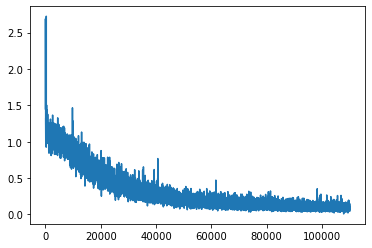

In [12]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        
        #eucledian_distance = F.pairwise_distance(output1, output2)
        
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            #print("Евклидово расстояние:-",eucledian_distance.argmax())
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

# Тестирование


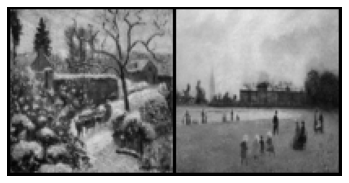

Евклидово расстояние:- 0.42292600870132446
Фактическое значение:- Один стиль
Предсказанное значение:- Один стиль


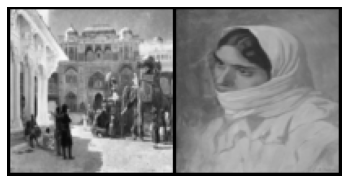

Евклидово расстояние:- 2.574293851852417
Фактическое значение:- Один стиль
Предсказанное значение:- Разные стили


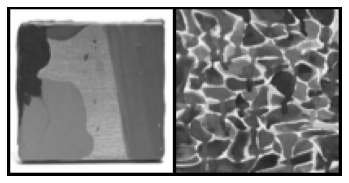

Евклидово расстояние:- 1.9990042448043823
Фактическое значение:- Один стиль
Предсказанное значение:- Разные стили


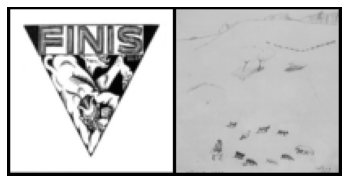

Евклидово расстояние:- 0.48632779717445374
Фактическое значение:- Один стиль
Предсказанное значение:- Один стиль


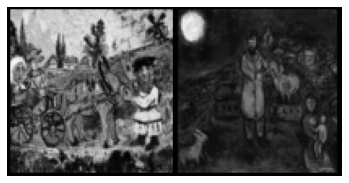

Евклидово расстояние:- 0.8558931946754456
Фактическое значение:- Один стиль
Предсказанное значение:- Один стиль


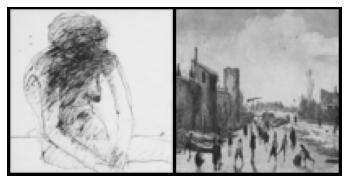

Евклидово расстояние:- 1.5866857767105103
Фактическое значение:- Разные стили
Предсказанное значение:- Разные стили


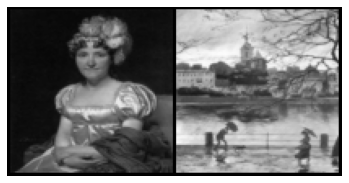

Евклидово расстояние:- 1.2930939197540283
Фактическое значение:- Разные стили
Предсказанное значение:- Разные стили


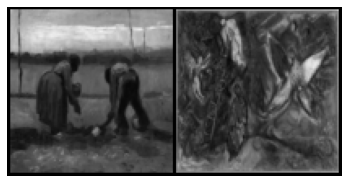

Евклидово расстояние:- 2.240826368331909
Фактическое значение:- Разные стили
Предсказанное значение:- Разные стили


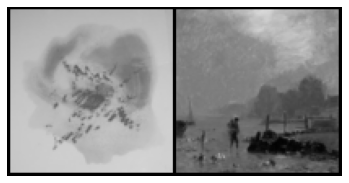

Евклидово расстояние:- 1.8085771799087524
Фактическое значение:- Разные стили
Предсказанное значение:- Разные стили


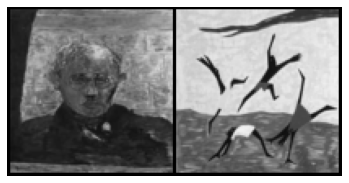

Евклидово расстояние:- 0.9551922678947449
Фактическое значение:- Разные стили
Предсказанное значение:- Один стиль
Accuracy:  0.7
Матрица ошибок:  [[3 2]
 [1 4]]


In [13]:
import sklearn.metrics

y_pred=[]
y_true=[]

# Загружаем тестовый набор данных
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                        ,should_invert=False)
test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
#тестируем сеть
count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = net(x0.cuda(),x1.cuda())

  eucledian_distance = F.pairwise_distance(output1, output2)
  if eucledian_distance < 1:
    y_pred.append("positive")
    label2 ="Один стиль"
  if eucledian_distance > 1:
    y_pred.append("negative")
    label2 ="Разные стили"
    
  if label==torch.FloatTensor([[0]]):
    label="Один стиль"
    y_true.append("positive")
  else:
    label="Разные стили"
    y_true.append("negative")
    
    
  imshow(torchvision.utils.make_grid(concat))
  print("Евклидово расстояние:-",eucledian_distance.item())
  print("Фактическое значение:-",label)
  print("Предсказанное значение:-",label2)
  count=count+1
  if count ==10:
     break
        
    
r = sklearn.metrics.confusion_matrix(y_true, y_pred)
r = np.flip(r)

acc = (r[0][0] + r[-1][-1]) / np.sum(r)
print("Accuracy: ", acc)

print("Матрица ошибок: ", r)

In [32]:
import sklearn.metrics

y_pred=[]
y_true=[]

# Загружаем тестовый набор данных
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                        ,should_invert=False)
test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
#тестируем сеть
count=0
for i, data in enumerate(test_dataloader,0): 
  print(count)  
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = net(x0.cuda(),x1.cuda())

  eucledian_distance = F.pairwise_distance(output1, output2)
    
  if eucledian_distance <= 1.2:
    y_pred.append("positive")
   
  if eucledian_distance > 1.2:
    y_pred.append("negative")
  
    
  if label==torch.FloatTensor([[0]]):
  
    y_true.append("positive")
  else:
  
    y_true.append("negative")
       
  count=count+1
  
r = sklearn.metrics.confusion_matrix(y_true, y_pred)
r = np.flip(r)

acc = (r[0][0] + r[-1][-1]) / np.sum(r)
print("Accuracy: ", acc)
print("Матрица ошибок: ")
print(r)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722


5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362


6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014


8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658


10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
1025

11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
1161

12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
1300

14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
1437

15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
1575

16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
1714

18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
1851

19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
1988

21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
2126

22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
2264

23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
2403

25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
2540

26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
2679

27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
2816

29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
2954

import pandas as pd # Библиотека для работы с датафреймом
df = pd.read_csv(r'H:\pythonProject\groundtruth_multiloss_test_header.csv')
df['style'].unique().shape
#df.head()